In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import torch
from torch.optim import SGD
from torch import nn

## Access src directory from ./notebooks/ folder
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
from src.models.example_net import ConvNet

from src.Snip_copy import SNIP
from src.optimization import epoch

import numpy as np
import matplotlib.pyplot as plt

### Manual test with F-MNIST

In [2]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

# Prepare dataloaders

In [3]:
pruning_batch_size = 128
batch_size = 64
path = '../data/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = FashionMNIST(path, train=True, download=True,transform=data_transforms)
test_dataset = FashionMNIST(path, train=False, download=True,transform=data_transforms)
pruning_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=pruning_batch_size, shuffle=True, num_workers=2)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model
In the beginning of each batch, use pruning to force the connections to zero.

In [4]:
def train_model(model, snip = None, epochs = 20):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model = model.cuda()
    criterion = criterion.cuda()
    
    if snip:
        hooks = snip.register_masks()
        assert snip.K == snip.get_nonzero_param_number()

    train_losses = []
    test_losses = []
    accuracys = []
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        _, loss = epoch(train_data_loader, 
                        model, 
                        criterion,
                        snip_pruning=snip, 
                        optimizer=optimizer,
                        PRINT_INTERVAL=-1)
        # Phase d'evaluation
        with torch.no_grad():
            acc_test, loss_test = epoch(test_data_loader, model, criterion)

        train_losses.append(loss.avg)
        test_losses.append(loss_test.avg)
        accuracys.append(acc_test.avg)

    if snip:
        for hook in hooks:
            hook.remove()
        nonzero_params = snip.get_nonzero_param_number()
        print(nonzero_params)
        assert snip.K == nonzero_params

    return train_losses, test_losses, accuracys

def print_losses_and_acc(training_losses_, test_losses_, acc_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)), test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(acc_)), acc_)
    plt.show()

In [5]:
original_model = ConvNet()
train_losses, test_losses, accuracys  = train_model(original_model);

=== EPOCH 1 =====


===============> Total time 3s	Avg loss 0.5484	Avg Prec  0.80 %

[EVAL Batch 000/157]	Time 0.080s (0.080s)	Loss 0.3923 (0.3923)	Prec 0.8438 (0.8438)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 0.5658 (0.4110)	Prec 0.7969 (0.8495)


===============> Total time 0s	Avg loss 0.4019	Avg Prec  0.85 %

=== EPOCH 2 =====


===============> Total time 3s	Avg loss 0.3561	Avg Prec  0.87 %

[EVAL Batch 000/157]	Time 0.079s (0.079s)	Loss 0.2028 (0.2028)	Prec 0.9219 (0.9219)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.3405 (0.3614)	Prec 0.8750 (0.8690)


===============> Total time 0s	Avg loss 0.3598	Avg Prec  0.87 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 0.3138	Avg Prec  0.88 %

[EVAL Batch 000/157]	Time 0.115s (0.115s)	Loss 0.3228 (0.3228)	Prec 0.8750 (0.8750)

[EVAL Batch 100/157]	Time 0.005s (0.004s)	Loss 0.3958 (0.3560)	Prec 0.8281 (0.8668)


===============> Total time 0s	Avg loss 0.3649	Avg Prec  0.87 %

=== EPOCH 4 =====


===============> 

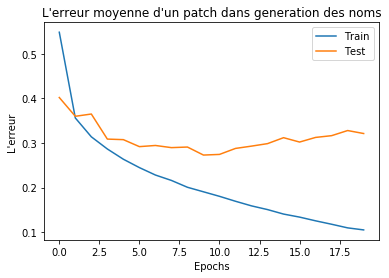

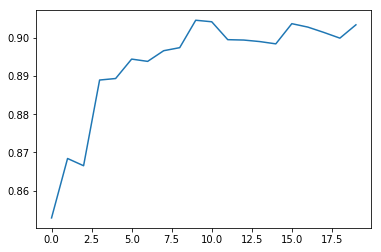

In [6]:
print_losses_and_acc(train_losses, test_losses, accuracys)

# Execute pruning
For given model, execute SNIP pruning using one batch of 128 examples. K is the number of connections to keep.

In [7]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 10
print("4 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
4 %  of params : 6170
=== EPOCH 1 =====


===============> Total time 3s	Avg loss 0.8078	Avg Prec  0.70 %

[EVAL Batch 000/157]	Time 0.060s (0.060s)	Loss 0.5456 (0.5456)	Prec 0.7812 (0.7812)

[EVAL Batch 100/157]	Time 0.004s (0.003s)	Loss 0.5481 (0.5245)	Prec 0.8281 (0.8021)


===============> Total time 0s	Avg loss 0.5322	Avg Prec  0.80 %

=== EPOCH 2 =====


===============> Total time 3s	Avg loss 0.4637	Avg Prec  0.83 %

[EVAL Batch 000/157]	Time 0.059s (0.059s)	Loss 0.4815 (0.4815)	Prec 0.7812 (0.7812)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.4786 (0.4355)	Prec 0.7969 (0.8393)


===============> Total time 0s	Avg loss 0.4392	Avg Prec  0.84 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 0.4025	Avg Prec  0.85 %

[EVAL Batch 000/157]	Time 0.060s (0.060s)	Loss 0.4651 (0.4651)	Prec 0.8281 (0.8281)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.5761 (0.4079)	Prec 0.8594 (0.8532)


===============> Total time 0s	Avg loss 0.4062

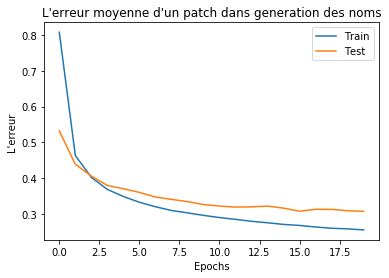

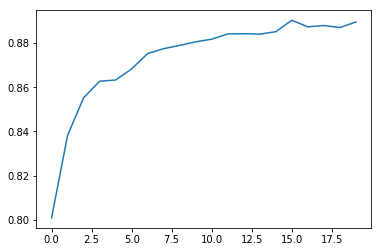

In [8]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Even less parameters


In [9]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 25
print("4 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
4 %  of params : 2468
=== EPOCH 1 =====


===============> Total time 3s	Avg loss 1.0975	Avg Prec  0.59 %

[EVAL Batch 000/157]	Time 0.063s (0.063s)	Loss 0.7652 (0.7652)	Prec 0.7656 (0.7656)

[EVAL Batch 100/157]	Time 0.003s (0.003s)	Loss 0.7034 (0.6822)	Prec 0.7656 (0.7539)


===============> Total time 0s	Avg loss 0.6909	Avg Prec  0.75 %

=== EPOCH 2 =====


===============> Total time 3s	Avg loss 0.5991	Avg Prec  0.78 %

[EVAL Batch 000/157]	Time 0.061s (0.061s)	Loss 0.5678 (0.5678)	Prec 0.7344 (0.7344)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 0.6178 (0.5614)	Prec 0.7656 (0.7881)


===============> Total time 0s	Avg loss 0.5652	Avg Prec  0.79 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 0.5182	Avg Prec  0.81 %

[EVAL Batch 000/157]	Time 0.064s (0.064s)	Loss 0.4615 (0.4615)	Prec 0.8125 (0.8125)

[EVAL Batch 100/157]	Time 0.002s (0.003s)	Loss 0.4184 (0.5131)	Prec 0.8281 (0.8071)


===============> Total time 0s	Avg loss 0.5171

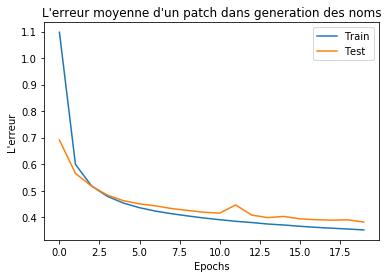

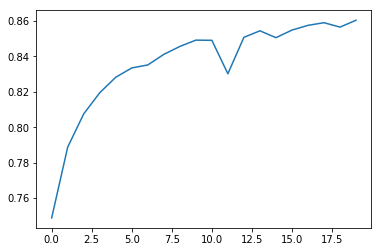

In [10]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Very small model

In [11]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 50
print("2 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
2 %  of params : 1234
=== EPOCH 1 =====


===============> Total time 3s	Avg loss 1.5604	Avg Prec  0.45 %

[EVAL Batch 000/157]	Time 0.063s (0.063s)	Loss 0.8994 (0.8994)	Prec 0.7031 (0.7031)

[EVAL Batch 100/157]	Time 0.002s (0.004s)	Loss 1.0822 (1.0392)	Prec 0.5469 (0.6236)


===============> Total time 0s	Avg loss 1.0342	Avg Prec  0.63 %

=== EPOCH 2 =====


===============> Total time 3s	Avg loss 0.9079	Avg Prec  0.66 %

[EVAL Batch 000/157]	Time 0.064s (0.064s)	Loss 0.7488 (0.7488)	Prec 0.6719 (0.6719)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.9438 (0.8380)	Prec 0.7188 (0.6742)


===============> Total time 0s	Avg loss 0.8364	Avg Prec  0.67 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 0.7989	Avg Prec  0.68 %

[EVAL Batch 000/157]	Time 0.064s (0.064s)	Loss 0.7387 (0.7387)	Prec 0.7188 (0.7188)

[EVAL Batch 100/157]	Time 0.003s (0.003s)	Loss 0.8193 (0.7741)	Prec 0.6250 (0.6864)


===============> Total time 0s	Avg loss 0.7830

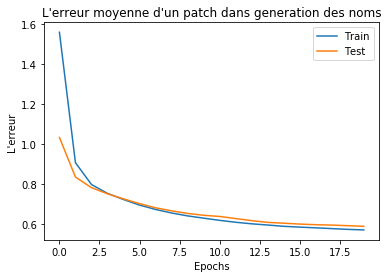

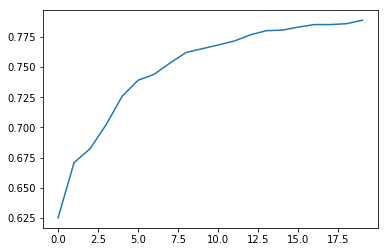

In [12]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### 1.5 % params

In [13]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = int(total_param_number * 0.015)
print("1.5 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
1.5 %  of params : 925
=== EPOCH 1 =====


===============> Total time 3s	Avg loss 1.9443	Avg Prec  0.22 %

[EVAL Batch 000/157]	Time 0.059s (0.059s)	Loss 1.6340 (1.6340)	Prec 0.3125 (0.3125)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 1.7178 (1.6863)	Prec 0.3438 (0.2865)


===============> Total time 0s	Avg loss 1.6875	Avg Prec  0.29 %

=== EPOCH 2 =====


===============> Total time 3s	Avg loss 1.6312	Avg Prec  0.35 %

[EVAL Batch 000/157]	Time 0.059s (0.059s)	Loss 1.5162 (1.5162)	Prec 0.4219 (0.4219)

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 1.6054 (1.5933)	Prec 0.3750 (0.4013)


===============> Total time 0s	Avg loss 1.5989	Avg Prec  0.40 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 1.5730	Avg Prec  0.40 %

[EVAL Batch 000/157]	Time 0.061s (0.061s)	Loss 1.5297 (1.5297)	Prec 0.4219 (0.4219)

[EVAL Batch 100/157]	Time 0.004s (0.003s)	Loss 1.6029 (1.5578)	Prec 0.3438 (0.4028)


===============> Total time 0s	Avg loss 1.557

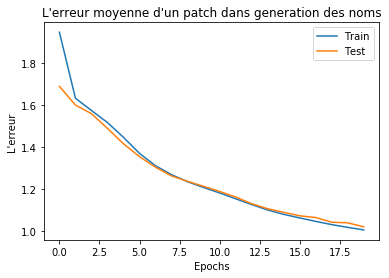

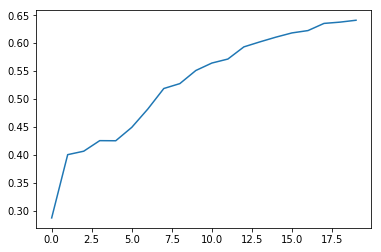

In [14]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Super small model

In [15]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 100
print("1 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
1 %  of params : 617
=== EPOCH 1 =====


===============> Total time 3s	Avg loss 2.1245	Avg Prec  0.18 %

[EVAL Batch 000/157]	Time 0.060s (0.060s)	Loss 1.9973 (1.9973)	Prec 0.1094 (0.1094)

[EVAL Batch 100/157]	Time 0.003s (0.003s)	Loss 1.9169 (1.9574)	Prec 0.2031 (0.1863)


===============> Total time 0s	Avg loss 1.9526	Avg Prec  0.19 %

=== EPOCH 2 =====


===============> Total time 4s	Avg loss 1.9172	Avg Prec  0.19 %

[EVAL Batch 000/157]	Time 0.062s (0.062s)	Loss 1.8679 (1.8679)	Prec 0.1719 (0.1719)

[EVAL Batch 100/157]	Time 0.004s (0.004s)	Loss 1.8742 (1.8999)	Prec 0.2031 (0.2036)


===============> Total time 0s	Avg loss 1.8925	Avg Prec  0.21 %

=== EPOCH 3 =====


===============> Total time 3s	Avg loss 1.8807	Avg Prec  0.20 %

[EVAL Batch 000/157]	Time 0.066s (0.066s)	Loss 2.0090 (2.0090)	Prec 0.2500 (0.2500)

[EVAL Batch 100/157]	Time 0.002s (0.004s)	Loss 1.8840 (1.8693)	Prec 0.2344 (0.1979)


===============> Total time 0s	Avg loss 1.8686	

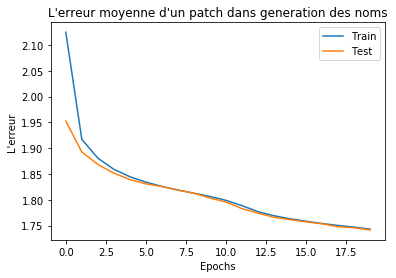

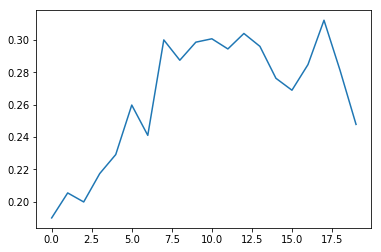

In [16]:
print_losses_and_acc(train_losses, test_losses, accuracys)